## Double DQN

To reduce the chance of positive bias we can ave two instances of the action-value function.

We can use the Huber loss: it is quadratic (curved) near-zero error, and it becomes linear (straight) for errors larger than a preset threshold.

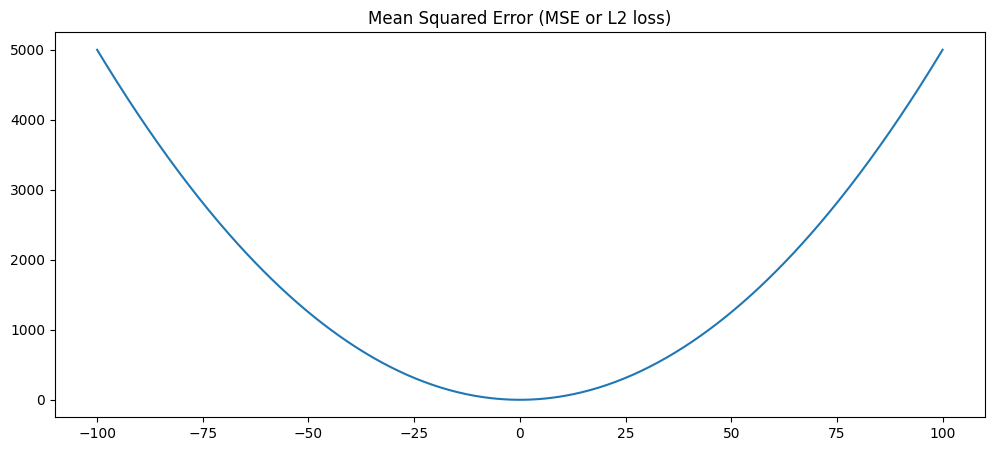

In [3]:
import matplotlib.pyplot as plt
import numpy as np

pred = np.linspace(-100,100,500)
truth = np.zeros(pred.shape)
error = truth - pred

mse = 0.5*error**2

plt.figure(figsize=(12,5))

plt.plot(pred, mse)
plt.title('Mean Squared Error (MSE or L2 loss)')
plt.show()


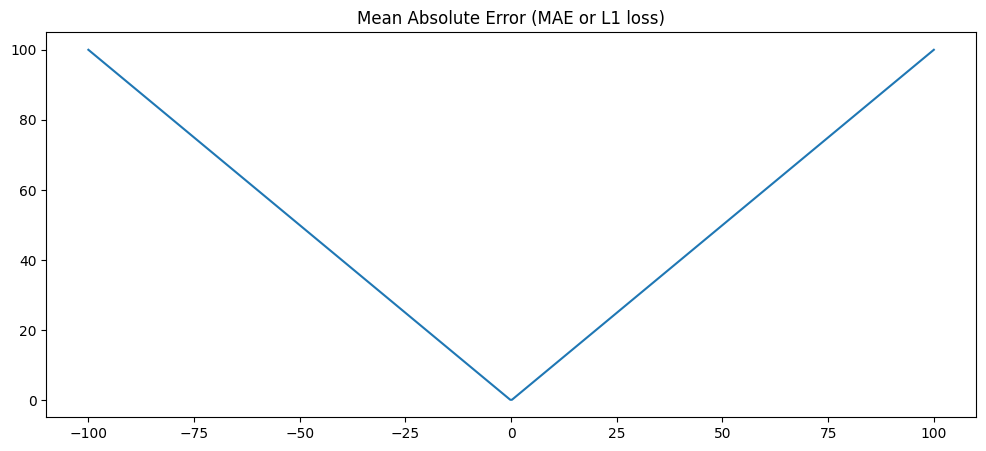

In [4]:
mae = np.abs(error)

plt.figure(figsize=(12,5))

plt.plot(pred, mae)
plt.title('Mean Absolute Error (MAE or L1 loss)')
plt.show()

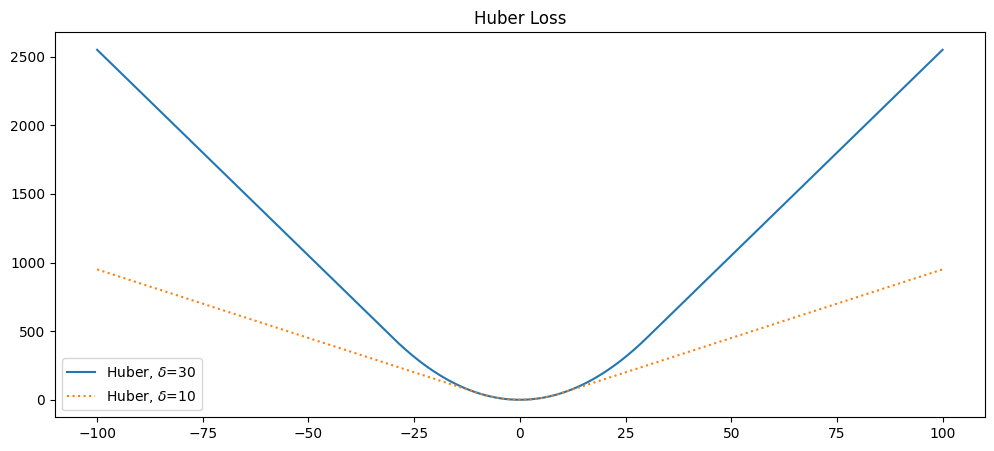

In [5]:
huber = lambda delta=1: mae - delta/2 if delta == 0 else \
              np.where(mae <= np.repeat(delta, len(mae)), mse, delta*(mae - delta/2))

plt.figure(figsize=(12,5))

plot1, = plt.plot(pred, huber(30))
plot2, = plt.plot(pred, huber(10), ':')
plt.title('Huber Loss')
plt.legend([plot1,plot2],["Huber, $\\delta$=30", "Huber, $\\delta$=10"])
plt.show()

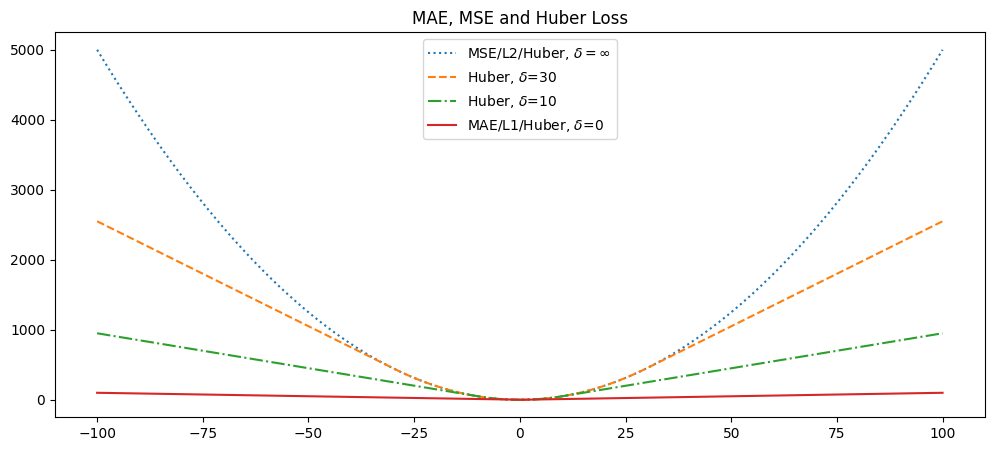

In [6]:
plt.figure(figsize=(12,5))

plot1, = plt.plot(pred, huber(float('inf')), ':')
plot2, = plt.plot(pred, huber(30), '--')
plot3, = plt.plot(pred, huber(10), '-.')
plot4, = plt.plot(pred, huber(0))

plt.title('MAE, MSE and Huber Loss')
plt.legend([plot1,plot2,plot3,plot4],["MSE/L2/Huber, $\\delta=\\infty$", "Huber, $\\delta$=30", "Huber, $\\delta$=10", "MAE/L1/Huber, $\\delta$=0"])
plt.show()

We can write the optimize_model function in order to use the Huber loss:

In [7]:
def optimize_model_ddqn(self, experiences):

    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_terminals = experiences

    # get the batch size
    batch_size = len(is_terminals)
        
    # get the values of the Q-function at next state (remember to detach
    # notice: we now query the "target" network to get the estimate of the next state 
    q_sp = self.target_model(next_states).detach()
        
    # get the max value of the next state
    max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
    
    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_a_q_sp *= (1 - is_terminals)
        
    # calculate the target 
    target_q_sa = rewards + self.gamma * max_a_q_sp

    # finally, we get the current estimate of Q(s,a)    
    # notice: here we query the current "online" network
    q_sa = self.online_model(states).gather(1, actions)

    # create the errors
    td_errors = q_sa - target_q_sa
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    self.optimizer.zero_grad()
    value_loss.backward()

    # clip the gradients to the max_gradient_norm.
    torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)
    
    self.optimizer.step()

We can put all things toghether and write the DDQN network, which is almost identical to DQN:

In [8]:
import random 
import torch
import torch.optim as optim

class DDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory, max_gradient_norm,
                 seed, n_warmup_batches, target_update_steps):
        
        # set the seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # store the objects
        self.env = env
        self.replay_memory = replay_memory
        self.max_gradient_norm = max_gradient_norm
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

The other methods and the network are the same of DQN:

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

         # creating the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        # connecting the output layer 
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        
        # finally, for the output layer
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

In [10]:
def interaction_step(self, state):
    
    # interact with environment using the exploration policy
    # notice how we use the online model for selecting actions
    action = self.train_strategy.select_action(self.online_model, state)

    # collect an experience tuple as usual    
    new_state, reward, is_terminal, is_truncated, info = self.env.step(action)

    # a failure is defined as follows
    is_failure = is_terminal and not is_truncated
    
    # collect the experience and store it in the replay buffer
    experience = (state, action, reward, new_state, float(is_failure))
    self.replay_memory.store(experience)

    # update episode stats
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
    
    return new_state, is_terminal

In [11]:
def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
        target.data.copy_(online.data)

In [12]:
def evaluate(self, n_episodes=1):

    # create a list of returns of each episode
    rs = []

    # loop over the episodes
    for _ in range(n_episodes):

        # reset the environment before starting the episode
        s, d = self.env.reset()[0], False

        # initialize the return
        rs.append(0)

        # interact with the environment until the episode is done 
        while(True):

            # interact with environment using the exploitation policy
            a = self.eval_strategy.select_action(self.online_model, s)

            # collect an experience tuple as usual
            s, r, d, t, _ = self.env.step(a)

             # add the reward to the return of the episode
            rs[-1] += r

            if d or t:
                break
            
    return np.mean(rs), np.std(rs)

In [13]:
class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        
        # initialize five arrays to hold states, actions, reward, next states, and done flags
        self.states      = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones       = np.empty(shape=(max_size), dtype=np.ndarray)

        # variables to do storage and sampling
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
    
    def store(self, sample):
        
        # store a new sample 
        state, action, reward, next_state, done = sample
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done

        # idx points to the next index to modify, so we increase it, 
        # also make sure it loops back after reaching the maximum size 
        # (the end of the buffer)
        self.idx += 1
        self.idx = self.idx % self.max_size

        # size also increases with every new sample stored, 
        # but it doesn’t loop back to 0; it stops growing instead
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        
        # determining the batch size
        if batch_size == None:
            batch_size = self.batch_size

        # sample batch_size ids from 0 to size.    
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        # extract the experiences from the buffer using the sampled ids
        experiences = np.vstack(self.states[idxs]), \
                      np.vstack(self.actions[idxs]), \
                      np.vstack(self.rewards[idxs]), \
                      np.vstack(self.next_states[idxs]), \
                      np.vstack(self.dones[idxs])
                      
        return experiences

    # handy function to return the correct size of the memory
    def __len__(self):
        return self.size

In [14]:
class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        #with torch.no_grad():
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action


In [15]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

In [16]:
from itertools import count
import time

def train(self, gamma, max_minutes, max_episodes, goal_reward):
        
        # timing variables
        training_start = time.time()

        self.gamma = gamma
        
        # stats trackers 
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        # we synchronize the online and target models at the beginning of training
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan

        training_time = 0
        
        # train until we either reach the max minutes, the max episodes or the goal mean reward
        for episode in range(1, max_episodes + 1):

            # get the start time of the episode
            episode_start = time.time()
            
            # reset the episode trackers
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # reset the environment before starting the episode
            state, is_terminal = self.env.reset()[0], False

            # interact with the environment until the episode is done
            for step in count():

                # interact with environment using the exploration policy
                # and collect the experience in the replay memory
                state, is_terminal = self.interaction_step(state)
                
                # if the replay memory has enough samples, we can create 
                # the mini-batch and optimize the model 
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:

                    # load the experiences as tensors for training
                    # from the replay memory
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)

                    # optimize the model
                    self.optimize_model(experiences)
                
                # synchronize the target model with the online model
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # timing stuff
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            # episode steps count
            total_step = int(np.sum(self.episode_timestep))

            # evaluate the learned policy after the episode
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            # average stats over some recent episodes
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            # report results
            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            # check max episodes, max minutes and goal achievement criteria
            total_elapsed = time.time() - training_start
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            # informative print logging  
            debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
            debug_message = debug_message.format(episode, total_step, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            
            # conclude training if we have met any of the stopping conditions
            if training_is_over:
                print(debug_message)
                if reached_max_minutes: print(u'--> reached_max_minutes ')
                if reached_max_episodes: print(u'--> reached_max_episodes ')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward ')
                break
                
        # evaluate the final policy
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time


In [17]:
DDQN.optimize_model = optimize_model_ddqn
DDQN.interaction_step = interaction_step
DDQN.update_network = update_network
DDQN.evaluate = evaluate
DDQN.train = train

DDQN and DQN have similar performance in the cart-pole environment. However, this is a simple environment with a smooth reward function. In real problems, DDQN should always give better performance.

In [18]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")

In [19]:
gamma = 1.00

max_minutes = 20
max_episodes = 10000
goal_reward = 350

ddqn_results = []
best_ddqn_agent = None 
best_ddqn_eval_score = float('-inf')

target_update_steps = 10
n_warmup_batches = 5

max_gradient_norm = float('inf')

nS, nA = cartpole.observation_space.shape[0], cartpole.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCQ(nS, nA, hidden_dims=(512,128))
    target_model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0007)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
    
    agent = DDQN(cartpole, online_model, target_model, optimizer, 
                train_strategy, eval_strategy, replay_memory, max_gradient_norm, 
                seed, n_warmup_batches, target_update_steps)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)

    ddqn_results.append(result)
    if score > best_ddqn_eval_score:
        best_ddqn_eval_score = score
        best_ddqn_agent = agent

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))
        
ddqn_results = np.array(ddqn_results)

Training started...
episode 0184, steps 042158, avg eval score 351.8 (+/- 130.3)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 73.88s training time

Training started...
episode 0169, steps 022263, avg eval score 350.7 (+/- 109.7)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 380.32±104.28 in 35.50s training time

Training started...
episode 0209, steps 040864, avg eval score 351.4 (+/- 145.5)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 458.92±102.43 in 70.72s training time

Training started...
episode 0183, steps 066483, avg eval score 351.4 (+/- 134.0)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 168.77s training time

Training started...
episode 0194, steps 040190, avg eval score 353.0 (+/- 102.7)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 464.37±88.34 in 69.13s training time



In [20]:
ddqn_max_steps, ddqn_max_train_reward, ddqn_max_eval_score, ddqn_max_time = np.max(ddqn_results, axis=0).T
ddqn_min_steps, ddqn_min_train_reward, ddqn_min_eval_score, ddqn_min_time = np.min(ddqn_results, axis=0).T
ddqn_mean_steps, ddqn_mean_train_reward, ddqn_mean_eval_score, ddqn_mean_time = np.mean(ddqn_results, axis=0).T
ddqn_episodes = np.arange(len(ddqn_mean_steps))

We can save the result to future comparison:

In [21]:
np.savez('ddqn_results',
         ddqn_max_steps = ddqn_max_steps, ddqn_max_train_reward = ddqn_max_train_reward, ddqn_max_eval_score = ddqn_max_eval_score, ddqn_max_time = ddqn_max_time,
         ddqn_min_steps = ddqn_min_steps, ddqn_min_train_reward = ddqn_min_train_reward, ddqn_min_eval_score = ddqn_min_eval_score, ddqn_min_time = ddqn_min_time,  
         ddqn_mean_steps = ddqn_mean_steps, ddqn_mean_train_reward = ddqn_mean_train_reward, ddqn_mean_eval_score = ddqn_mean_eval_score, ddqn_mean_time = ddqn_mean_time)


We can load the result of DQN in order to compare the performances of the two algorithms:

In [22]:
dqn_results = np.load('dqn_results.npz')
dqn_max_steps = dqn_results['dqn_max_steps']
dqn_max_train_reward = dqn_results['dqn_max_train_reward']
dqn_max_eval_score = dqn_results['dqn_max_eval_score']
dqn_max_time = dqn_results['dqn_max_time']
dqn_min_steps = dqn_results['dqn_min_steps']
dqn_min_train_reward = dqn_results['dqn_min_train_reward']
dqn_min_eval_score = dqn_results['dqn_min_eval_score']
dqn_min_time = dqn_results['dqn_min_time']
dqn_mean_steps = dqn_results['dqn_mean_steps']
dqn_mean_train_reward = dqn_results['dqn_mean_train_reward']
dqn_mean_eval_score = dqn_results['dqn_mean_eval_score']
dqn_mean_time = dqn_results['dqn_mean_time']
dqn_episodes = np.arange(len(dqn_mean_steps))

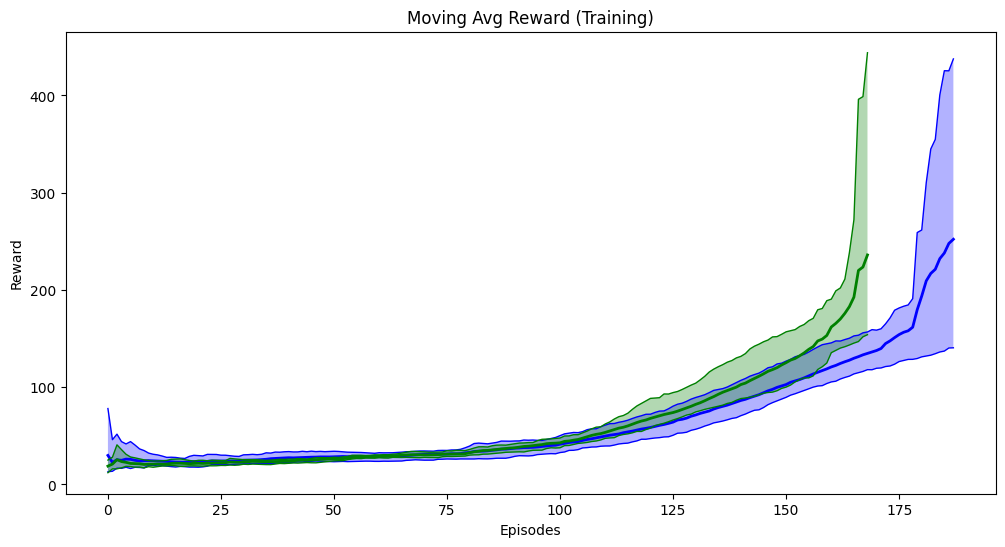

In [23]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_train_reward, 'b', linewidth=1)
plt.plot(dqn_min_train_reward, 'b', linewidth=1)
plt.plot(dqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_train_reward, dqn_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_train_reward, 'g', linewidth=1)
plt.plot(ddqn_min_train_reward, 'g', linewidth=1)
plt.plot(ddqn_mean_train_reward, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_train_reward, ddqn_max_train_reward, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

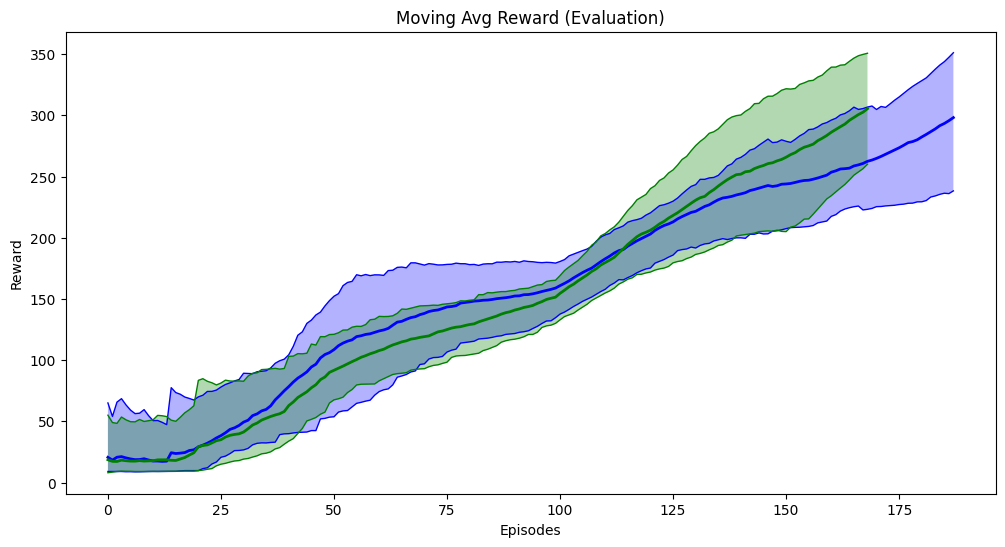

In [24]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_eval_score, 'b', linewidth=1)
plt.plot(dqn_min_eval_score, 'b', linewidth=1)
plt.plot(dqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_eval_score, dqn_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_eval_score, 'g', linewidth=1)
plt.plot(ddqn_min_eval_score, 'g', linewidth=1)
plt.plot(ddqn_mean_eval_score, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_eval_score, ddqn_max_eval_score, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Notice the top and bottom bounds (representing the maximum and minimum values obtained by any of the five seeds during that episode). DDQN shows tighter bounds demonstrating **more stability** on performance.

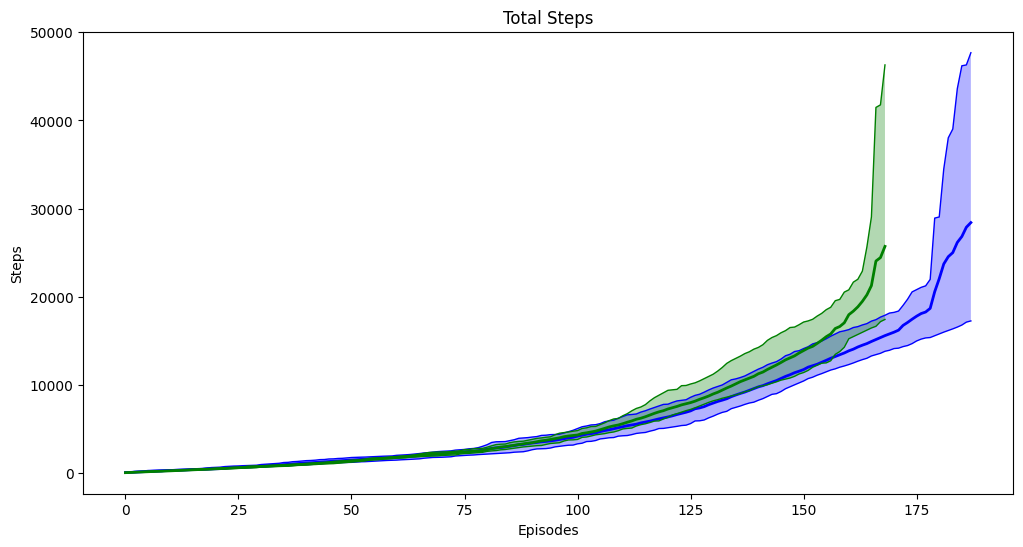

In [25]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_steps, 'b', linewidth=1)
plt.plot(dqn_min_steps, 'b', linewidth=1)
plt.plot(dqn_mean_steps, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_steps, dqn_max_steps, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_steps, 'g', linewidth=1)
plt.plot(ddqn_min_steps, 'g', linewidth=1)
plt.plot(ddqn_mean_steps, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_steps, ddqn_max_steps, facecolor='g', alpha=0.3)

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')
plt.show()

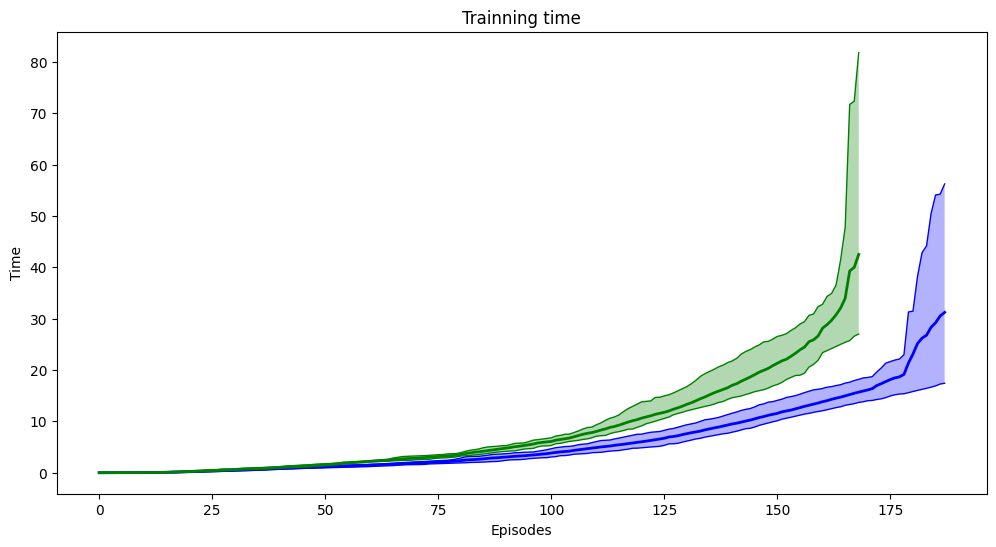

In [26]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_time, 'b', linewidth=1)
plt.plot(dqn_min_time, 'b', linewidth=1)
plt.plot(dqn_mean_time, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_time, dqn_max_time, facecolor='b', alpha=0.3)

plt.plot(ddqn_max_time, 'g', linewidth=1)
plt.plot(ddqn_min_time, 'g', linewidth=1)
plt.plot(ddqn_mean_time, 'g', linewidth=2)
plt.fill_between(ddqn_episodes, ddqn_min_time, ddqn_max_time, facecolor='g', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

In terms of time, DDQN take a bit longer than DQN to successfully pass the environment.